#### Imports

In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/persian-numbers/Train 60000.cdb
../input/persian-numbers/RemainingSamples.cdb
../input/persian-numbers/Test 20000.cdb
../input/persian-numbers/ReadCDB_VC/ReadCDB_VC.exe
../input/persian-numbers/ReadCDB_VC/resource.h
../input/persian-numbers/ReadCDB_VC/ReadCDB_VC.rc
../input/persian-numbers/ReadCDB_VC/stdafx.cpp
../input/persian-numbers/ReadCDB_VC/ReadMe.txt
../input/persian-numbers/ReadCDB_VC/ReadCDB_VC.cpp
../input/persian-numbers/ReadCDB_VC/ReadCDB_VCDlg.cpp
../input/persian-numbers/ReadCDB_VC/stdafx.h
../input/persian-numbers/ReadCDB_VC/ReadCDB_VC.sln
../input/persian-numbers/ReadCDB_VC/ReadCDB_VCDlg.h
../input/persian-numbers/ReadCDB_VC/ReadCDB_VC.vcproj
../input/persian-numbers/ReadCDB_VC/ReadCDB_VC.h
../input/persian-numbers/ReadCDB_VC/res/ReadCDB_VC.rc2
../input/persian-numbers/ReadCDB_VC/res/ReadCDB_VC.ico
../input/persian-numbers/ReadCDB_VC/res/ReadCDB_VC.manifest
../input/persian-numbers/ReadCDB_Matlab/ReadCDB_Matlab.m
../input/persian-numbers/ReadCDB_Delphi/ReadCDB-

In [97]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#import external libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
import itertools
import math
import time
%matplotlib inline

Check for CUDA

In [98]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device)

True
True
cuda


#### Read inputs

#### Separate into labels and training images and reshape the images

In [99]:

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=int)
    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [100]:
train_images, train_labels = read_hoda_dataset(dataset_path='../input/persian-numbers/Train 60000.cdb',
                                images_height=40,
                                images_width=40,
                                one_hot=False,
                                reshape=True)




In [101]:
x_test_val, y_test_val = read_hoda_dataset(dataset_path='../input/persian-numbers/Test 20000.cdb',
                                images_height=40,
                                images_width=40,
                                one_hot=False,
                                reshape=True)

test_images, val_images, test_labels, val_labels = train_test_split(
    x_test_val.astype(np.float32), y_test_val, test_size=0.5, random_state=50)

In [102]:
print(train_images.shape[0])
print(train_images[0].shape)

print(val_images.shape[0])
print(val_images[0].shape)

print(test_images.shape[0])
print(test_images[0].shape)



60000
(1600,)
10000
(1600,)
10000
(1600,)


In [103]:
train_images = train_images.reshape(train_images.shape[0], 40, 40)
val_images = val_images.reshape(val_images.shape[0], 40, 40)
test_images = test_images.reshape(test_images.shape[0], 40, 40)

#### Plot some images to see samples

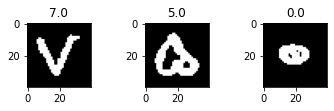

In [104]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

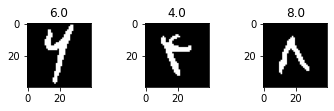

In [105]:
#val samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(val_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(val_labels[i])

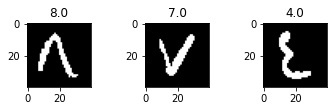

In [106]:

#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(test_labels[i])

#### Convert images to tensors
Normalize the images too

In [107]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor.type(torch.LongTensor))

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor.type(torch.LongTensor))

#test
test_images_tensor = torch.tensor(test_images)/255.0

#### Load images into the data generator

In [108]:
train_loader = DataLoader(train_tensor, batch_size=40, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=40, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=40, num_workers=2, shuffle=False)

#### Plot some sample images using the data generator

#### Define the CNN Model

In [109]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.1),
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.2),
        )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.3),
        )
        
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.4),
        )
        
        self.linear_block = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [110]:
conv_model = Net()
conv_model

Net(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(2

In [111]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [112]:
from torchsummary import summary
summary(conv_model, (1, 40, 40))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 19, 19]          --
|    └─Conv2d: 2-1                       [-1, 64, 40, 40]          640
|    └─ReLU: 2-2                         [-1, 64, 40, 40]          --
|    └─BatchNorm2d: 2-3                  [-1, 64, 40, 40]          128
|    └─MaxPool2d: 2-4                    [-1, 64, 19, 19]          --
|    └─Dropout: 2-5                      [-1, 64, 19, 19]          --
├─Sequential: 1-2                        [-1, 128, 9, 9]           --
|    └─Conv2d: 2-6                       [-1, 128, 19, 19]         73,856
|    └─ReLU: 2-7                         [-1, 128, 19, 19]         --
|    └─BatchNorm2d: 2-8                  [-1, 128, 19, 19]         256
|    └─Conv2d: 2-9                       [-1, 128, 19, 19]         147,584
|    └─ReLU: 2-10                        [-1, 128, 19, 19]         --
|    └─BatchNorm2d: 2-11                 [-1, 128, 19, 19]         256
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 19, 19]          --
|    └─Conv2d: 2-1                       [-1, 64, 40, 40]          640
|    └─ReLU: 2-2                         [-1, 64, 40, 40]          --
|    └─BatchNorm2d: 2-3                  [-1, 64, 40, 40]          128
|    └─MaxPool2d: 2-4                    [-1, 64, 19, 19]          --
|    └─Dropout: 2-5                      [-1, 64, 19, 19]          --
├─Sequential: 1-2                        [-1, 128, 9, 9]           --
|    └─Conv2d: 2-6                       [-1, 128, 19, 19]         73,856
|    └─ReLU: 2-7                         [-1, 128, 19, 19]         --
|    └─BatchNorm2d: 2-8                  [-1, 128, 19, 19]         256
|    └─Conv2d: 2-9                       [-1, 128, 19, 19]         147,584
|    └─ReLU: 2-10                        [-1, 128, 19, 19]         --
|    └─BatchNorm2d: 2-11                 [-1, 128, 19, 19]         256
| 

#### Define the optimizer and loss functions

In [113]:
optimizer_Adam = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_Adam, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

#### Training the Model

In [114]:
acc={'Val_acc':[] , 'Loss':[]}
def train_model(num_epoch, optimizer):
    conv_model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = conv_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
    exp_lr_scheduler.step()
def evaluate(data_loader):
    conv_model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = conv_model(data)
        
        loss += F.cross_entropy(output, target, reduction='sum').data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    
    acc['Val_acc'].append(100. * correct / len(data_loader.dataset))
    acc['Loss'].append(loss)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    

In [115]:
#num_epochs = 25
#start_time = time.time()
num_epochs = 20
for n in range(num_epochs):
    train_model(n,optimizer_Adam)
    evaluate(val_loader)


Train Epoch: 0 [4000/60000 (7%)]	Loss: 1.539481
Train Epoch: 0 [8000/60000 (13%)]	Loss: 1.575639
Train Epoch: 0 [12000/60000 (20%)]	Loss: 1.492587
Train Epoch: 0 [16000/60000 (27%)]	Loss: 1.548504
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.511472
Train Epoch: 0 [24000/60000 (40%)]	Loss: 1.485666
Train Epoch: 0 [28000/60000 (47%)]	Loss: 1.513132
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.508070
Train Epoch: 0 [36000/60000 (60%)]	Loss: 1.506663
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.461321
Train Epoch: 0 [44000/60000 (73%)]	Loss: 1.488948
Train Epoch: 0 [48000/60000 (80%)]	Loss: 1.561316
Train Epoch: 0 [52000/60000 (87%)]	Loss: 1.486455
Train Epoch: 0 [56000/60000 (93%)]	Loss: 1.465539
Train Epoch: 0 [60000/60000 (100%)]	Loss: 1.486158

Average Val Loss: 1.7020, Val Accuracy: 7582/10000 (75.820%)

Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.461151
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.484329
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.486172
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1

**Plot Accuracy**

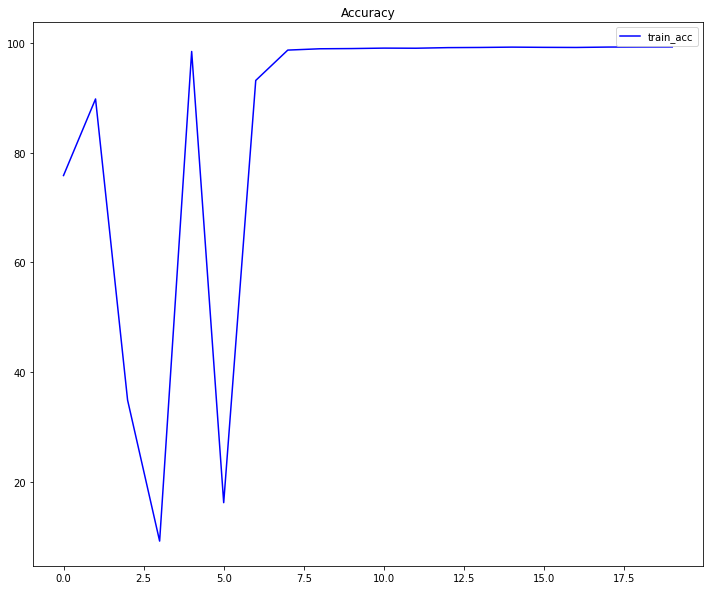

In [116]:
plt.figure(figsize = (12,10))
plt.plot(acc['Val_acc'], color = 'blue', label = 'train_acc')
plt.legend()
plt.title('Accuracy')
plt.savefig('acc_Adam.png')
plt.show()

**Plot Loss**

In [117]:
#convert a list of cuda tensors to a list of cpu tensors
loss_val = torch.tensor(acc['Loss'], device = 'cpu')

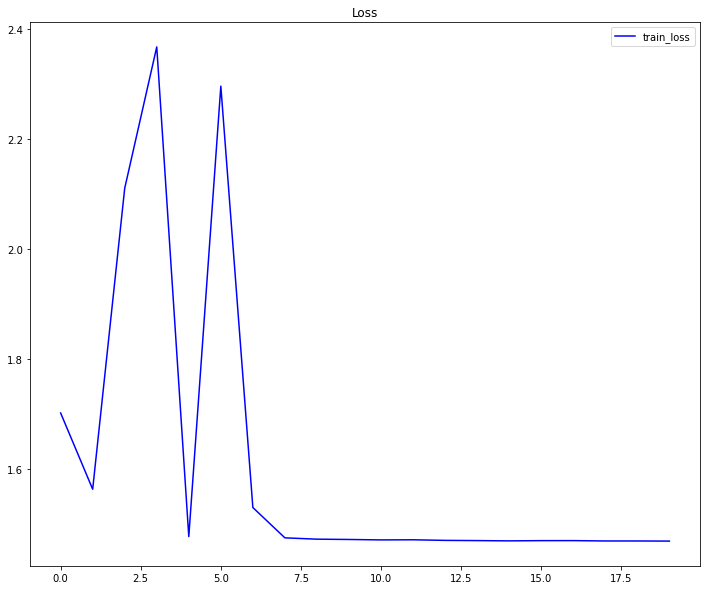

In [118]:
plt.figure(figsize = (12,10))
plt.plot(loss_val, color = 'blue', label = 'train_loss')
plt.legend()
plt.title('Loss')
plt.savefig('Loss_Adam.png')
plt.show()

#### Make predictions on the test set

In [119]:
def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = conv_model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [120]:
test_set_preds = make_predictions(test_loader)
test_set_preds

tensor([[2],
        [9],
        [7],
        ...,
        [5],
        [2],
        [7]])

In [121]:
test_loader

In [122]:
cm = confusion_matrix(test_labels, test_set_preds)
cm

array([[1027,    1,    0,    0,    2,    0,    0,    2,    0,    0],
       [   0,  996,    0,    0,    0,    0,    0,    0,    0,    1],
       [   0,    1,  957,    3,    3,    0,    0,    1,    1,    3],
       [   0,    0,   12,  988,   12,    0,    0,    0,    0,    0],
       [   1,    0,    1,    2,  990,    0,    0,    0,    0,    1],
       [   1,    0,    1,    0,    2, 1017,    0,    0,    0,    0],
       [   0,    2,    1,    1,    2,    3,  986,    0,    0,    3],
       [   0,    1,    1,    0,    1,    0,    0, 1040,    0,    0],
       [   0,    1,    0,    0,    0,    0,    0,    0,  976,    1],
       [   0,    5,    0,    0,    0,    0,    2,    1,    0,  947]])

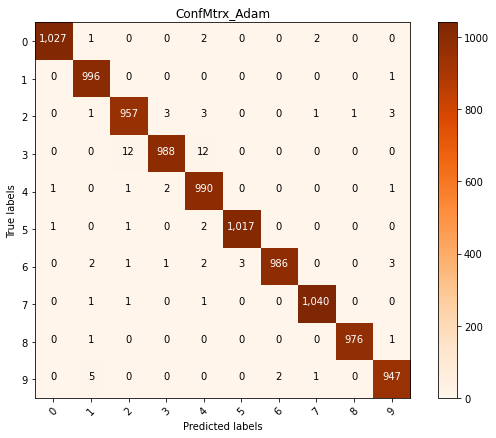

In [123]:


def plot_confusion_matrix(cm, target_names,title, cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
target_names = ('0','1', '2', '3', '4', '5', 
                 '6', '7', '8', '9')
plot_confusion_matrix(cm, target_names,title = 'ConfMtrx_Adam')

 2    9    7    0    4    0    8    7    4   

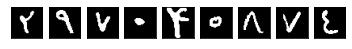

In [124]:
#test samples
for i in range(9):
    plt.subplot(1,9,i+1, xticks=[], yticks=[])
    print(f' {test_set_preds[i].item()}' , end="   ")
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))
plt.show()




In [125]:
wrongs=[]
for i,v in enumerate(test_set_preds):
    if v.item() != test_labels[i]:
        wrongs.append(i)

 4    1    4    1    2    2    4    2    5   

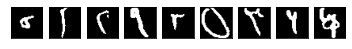

In [126]:
#Mistakes
for i,value in enumerate(wrongs[:9]):
    plt.subplot(1,9,i+1, xticks=[], yticks=[])
    print(f' {test_set_preds[value].item()}' , end="   ")
    plt.imshow(test_images[value].squeeze(), cmap=plt.get_cmap('gray'))
plt.show()


In [127]:
accuracy_score(test_labels , test_set_preds)

0.9924

In [128]:
print(classification_report(test_set_preds, test_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1029
           1       1.00      0.99      0.99      1007
           2       0.99      0.98      0.99       973
           3       0.98      0.99      0.99       994
           4       0.99      0.98      0.99      1012
           5       1.00      1.00      1.00      1020
           6       0.99      1.00      0.99       988
           7       1.00      1.00      1.00      1044
           8       1.00      1.00      1.00       977
           9       0.99      0.99      0.99       956

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Momentum

In [129]:
optimizer_mumentum = optim.SGD(conv_model.parameters(), lr=0.003, momentum=0.9)
#optimizer = optim.RMSprop(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_mumentum, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

In [130]:
acc={'Val_acc':[] , 'Loss':[]}
num_epochs = 20
for n in range(num_epochs):
    train_model(n, optimizer_mumentum)
    evaluate(val_loader)


Train Epoch: 0 [4000/60000 (7%)]	Loss: 1.461151
Train Epoch: 0 [8000/60000 (13%)]	Loss: 1.461151
Train Epoch: 0 [12000/60000 (20%)]	Loss: 1.486151
Train Epoch: 0 [16000/60000 (27%)]	Loss: 1.461151
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.486151
Train Epoch: 0 [24000/60000 (40%)]	Loss: 1.461151
Train Epoch: 0 [28000/60000 (47%)]	Loss: 1.461151
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.461151
Train Epoch: 0 [36000/60000 (60%)]	Loss: 1.461151
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.461151
Train Epoch: 0 [44000/60000 (73%)]	Loss: 1.461151
Train Epoch: 0 [48000/60000 (80%)]	Loss: 1.486151
Train Epoch: 0 [52000/60000 (87%)]	Loss: 1.461151
Train Epoch: 0 [56000/60000 (93%)]	Loss: 1.461151
Train Epoch: 0 [60000/60000 (100%)]	Loss: 1.486151

Average Val Loss: 1.4692, Val Accuracy: 9919/10000 (99.190%)

Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.461151
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.463260
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.461151
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1

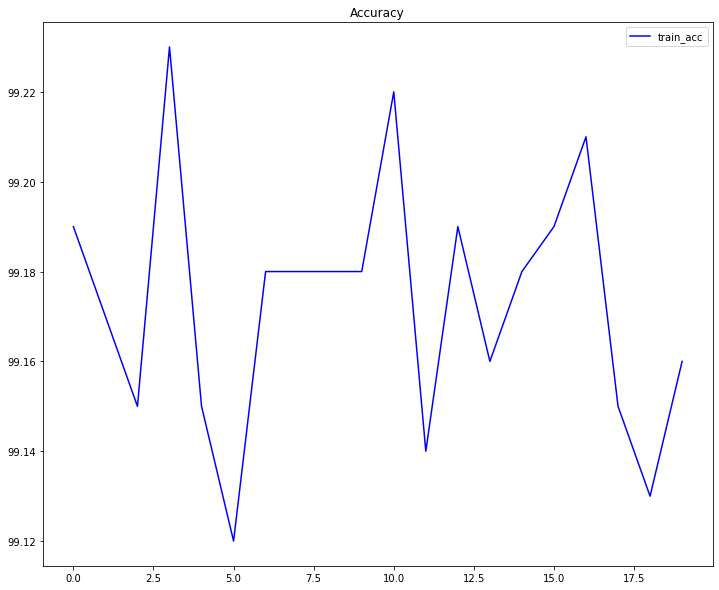

In [131]:
plt.figure(figsize = (12,10))
plt.plot(acc['Val_acc'], color = 'blue', label = 'train_acc')
plt.legend()
plt.title('Accuracy')
plt.savefig('acc_Momentum.png')
plt.show()

In [132]:
loss_val = torch.tensor(acc['Loss'], device = 'cpu')

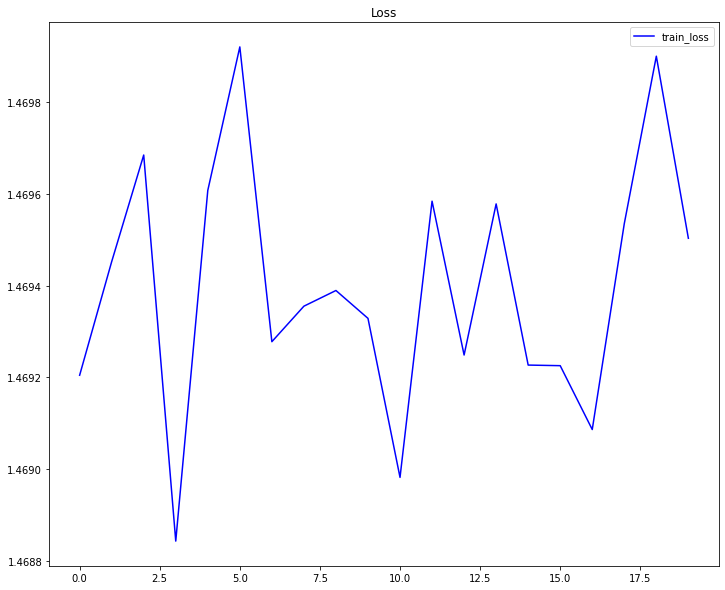

In [133]:
plt.figure(figsize = (12,10))
plt.plot(loss_val, color = 'blue', label = 'train_loss')
plt.legend()
plt.title('Loss')
plt.savefig('Loss_momentum.png')
plt.show()

In [134]:
test_set_preds = make_predictions(test_loader)

In [135]:
cm = confusion_matrix(test_labels, test_set_preds)
cm

array([[1025,    1,    0,    0,    2,    2,    0,    2,    0,    0],
       [   0,  993,    0,    3,    0,    0,    0,    0,    0,    1],
       [   0,    1,  957,    3,    2,    0,    0,    1,    0,    5],
       [   0,    0,   10,  991,   11,    0,    0,    0,    0,    0],
       [   0,    1,    2,    2,  989,    0,    0,    0,    0,    1],
       [   0,    0,    0,    0,    3, 1018,    0,    0,    0,    0],
       [   1,    2,    1,    1,    2,    3,  982,    0,    0,    6],
       [   0,    1,    1,    0,    0,    1,    0, 1040,    0,    0],
       [   0,    2,    0,    0,    0,    0,    0,    0,  975,    1],
       [   0,    5,    0,    0,    0,    0,    1,    1,    0,  948]])

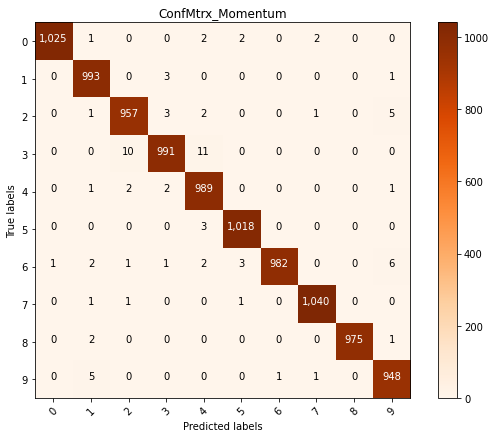

In [136]:
plot_confusion_matrix(cm, target_names, title = 'ConfMtrx_Momentum')

 2    9    7    0    4    0    8    7    4   

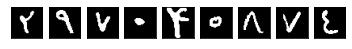

In [137]:
#test samples
for i in range(9):
    plt.subplot(1,9,i+1, xticks=[], yticks=[])
    print(f' {test_set_preds[i].item()}' , end="   ")
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))
plt.show()

In [138]:
accuracy_score(test_labels , test_set_preds)

0.9918

In [139]:
print(classification_report(test_set_preds, test_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1026
           1       1.00      0.99      0.99      1006
           2       0.99      0.99      0.99       971
           3       0.98      0.99      0.99      1000
           4       0.99      0.98      0.99      1009
           5       1.00      0.99      1.00      1024
           6       0.98      1.00      0.99       983
           7       1.00      1.00      1.00      1044
           8       1.00      1.00      1.00       975
           9       0.99      0.99      0.99       962

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [140]:
wrongs=[]
for i,v in enumerate(test_set_preds):
    if v.item() != test_labels[i]:
        wrongs.append(i)

 1    4    1    4    1    2    4    2    5   

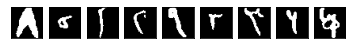

In [141]:
#Mistakes
for i,value in enumerate(wrongs[:9]):
    plt.subplot(1,9,i+1, xticks=[], yticks=[])
    print(f' {test_set_preds[value].item()}' , end="   ")
    plt.imshow(test_images[value].squeeze(), cmap=plt.get_cmap('gray'))
plt.show()

## Adadelta

In [142]:
optimizer_adadelta = torch.optim.Adadelta(conv_model.parameters() , lr=0.003, rho=0.9, eps=1e-06)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_adadelta, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

In [143]:
acc={'Val_acc':[] , 'Loss':[]}
num_epochs = 20
for n in range(num_epochs):
    train_model(n, optimizer_adadelta)
    evaluate(val_loader)

Train Epoch: 0 [4000/60000 (7%)]	Loss: 1.461151
Train Epoch: 0 [8000/60000 (13%)]	Loss: 1.461151
Train Epoch: 0 [12000/60000 (20%)]	Loss: 1.461151
Train Epoch: 0 [16000/60000 (27%)]	Loss: 1.486089
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.461151
Train Epoch: 0 [24000/60000 (40%)]	Loss: 1.461151
Train Epoch: 0 [28000/60000 (47%)]	Loss: 1.461151
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.461151
Train Epoch: 0 [36000/60000 (60%)]	Loss: 1.461151
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.461151
Train Epoch: 0 [44000/60000 (73%)]	Loss: 1.461151
Train Epoch: 0 [48000/60000 (80%)]	Loss: 1.461151
Train Epoch: 0 [52000/60000 (87%)]	Loss: 1.461151
Train Epoch: 0 [56000/60000 (93%)]	Loss: 1.461151
Train Epoch: 0 [60000/60000 (100%)]	Loss: 1.461151

Average Val Loss: 1.4688, Val Accuracy: 9924/10000 (99.240%)

Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.486151
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.461151
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.461151
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1

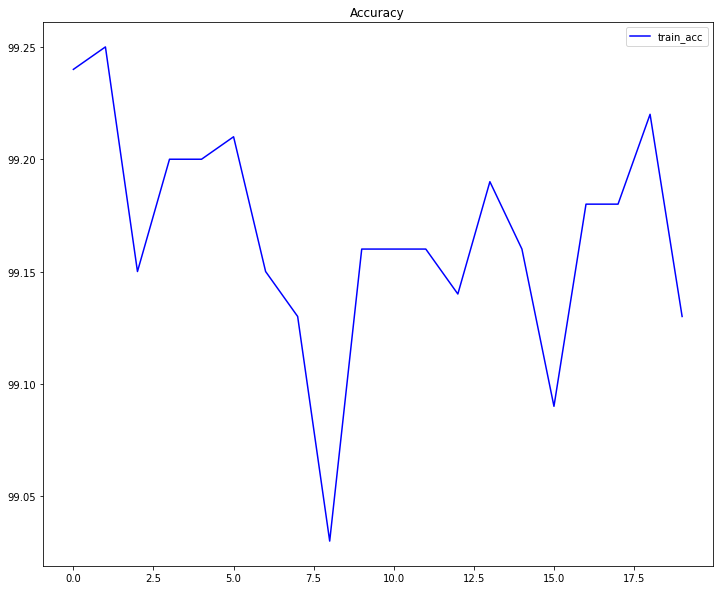

In [144]:
plt.figure(figsize = (12,10))
plt.plot(acc['Val_acc'], color = 'blue', label = 'train_acc')
plt.legend()
plt.title('Accuracy')
plt.savefig('acc_Adadelta.png')
plt.show()

In [145]:
loss_val = torch.tensor(acc['Loss'], device = 'cpu')

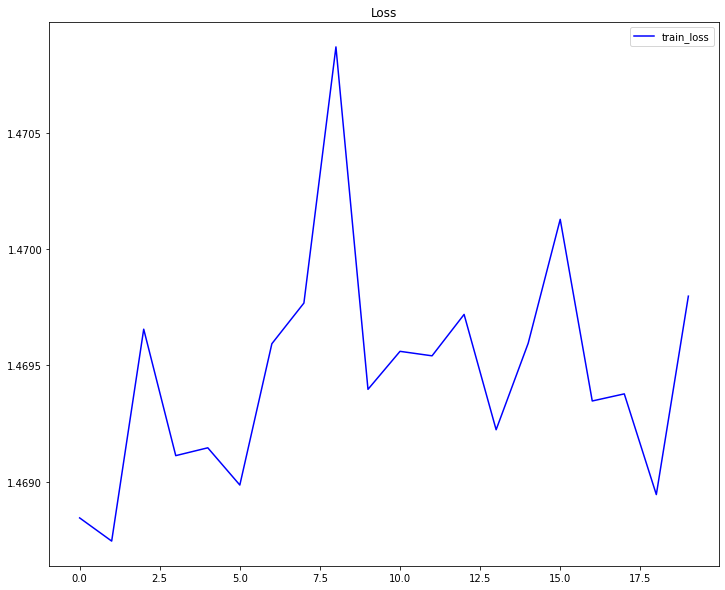

In [146]:
plt.figure(figsize = (12,10))
plt.plot(loss_val, color = 'blue', label = 'train_loss')
plt.legend()
plt.title('Loss')
plt.savefig('Loss_Adadelta.png')
plt.show()

In [147]:
test_set_preds = make_predictions(test_loader)


In [148]:
cm = confusion_matrix(test_labels, test_set_preds)
cm

array([[1024,    1,    0,    0,    2,    3,    0,    2,    0,    0],
       [   1,  992,    0,    3,    0,    0,    0,    0,    0,    1],
       [   1,    1,  958,    4,    2,    0,    0,    1,    0,    2],
       [   0,    0,   11,  990,   11,    0,    0,    0,    0,    0],
       [   1,    1,    2,    2,  989,    0,    0,    0,    0,    0],
       [   1,    0,    0,    0,    1, 1019,    0,    0,    0,    0],
       [   1,    2,    1,    2,    1,    3,  984,    0,    0,    4],
       [   0,    1,    1,    0,    0,    1,    0, 1039,    1,    0],
       [   0,    1,    0,    0,    0,    0,    0,    0,  976,    1],
       [   0,    5,    0,    0,    0,    0,    2,    1,    0,  947]])

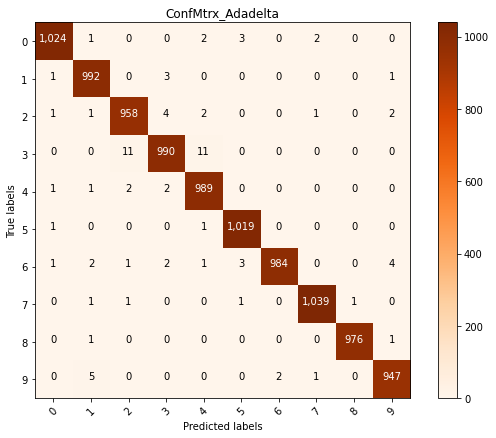

In [149]:
plot_confusion_matrix(cm, target_names, title = 'ConfMtrx_Adadelta')

 2    9    7    0    4    0    8    7    4   

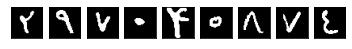

In [150]:
#test samples
for i in range(9):
    plt.subplot(1,9,i+1, xticks=[], yticks=[])
    print(f' {test_set_preds[i].item()}' , end="   ")
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))
plt.show()

In [151]:

accuracy_score(test_labels , test_set_preds)

0.9918

In [152]:
print(classification_report(test_set_preds, test_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1029
           1       0.99      0.99      0.99      1004
           2       0.99      0.98      0.99       973
           3       0.98      0.99      0.98      1001
           4       0.99      0.98      0.99      1006
           5       1.00      0.99      1.00      1026
           6       0.99      1.00      0.99       986
           7       1.00      1.00      1.00      1043
           8       1.00      1.00      1.00       977
           9       0.99      0.99      0.99       955

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [153]:
wrongs=[]
for i,v in enumerate(test_set_preds):
    if v.item() != test_labels[i]:
        wrongs.append(i)

 4    1    4    1    2    4    2    5    3   

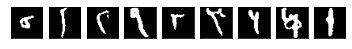

In [154]:
#Mistakes
for i,value in enumerate(wrongs[:9]):
    plt.subplot(1,9,i+1, xticks=[], yticks=[])
    print(f' {test_set_preds[value].item()}' , end="   ")
    plt.imshow(test_images[value].squeeze(), cmap=plt.get_cmap('gray'))
plt.show()